In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import lightgbm
import json
from sklearn.model_selection import StratifiedKFold

import category_encoders

In [2]:
import typing

import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1


def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.
    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= -4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2  # type: ignore
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2  # type: ignore
    else:
        return 9


def deviation_metric(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()  # type: ignore


def median_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.median(np.abs(y_pred - y_true) / y_true)  # type: ignore


def metrics_stat(y_true: np.ndarray, y_pred: np.ndarray) -> typing.Dict[str, float]:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {
        "mape": mape,
        "mdape": mdape,
        "rmse": rmse,
        "r2": r2,
        "raif_metric": raif_metric,
    }

In [3]:
cat_features = [
    'city', 'floor', 'realty_type', 'region', 'price_type', 'osm_city_nearest_name'
]
num_features = [
    'lat', 'lng',
    'osm_amenity_points_in_0.001', 'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
    'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001', 'osm_building_points_in_0.005', 
    'osm_building_points_in_0.0075', 'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
    'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075', 'osm_catering_points_in_0.01',
    'osm_city_closest_dist', 'osm_city_nearest_population', 
    'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001', 'osm_crossing_points_in_0.005',
    'osm_crossing_points_in_0.0075', 'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
    'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075', 'osm_culture_points_in_0.01', 
    'osm_finance_points_in_0.001', 'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075', 
    'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005', 'osm_healthcare_points_in_0.0075',
    'osm_healthcare_points_in_0.01', 'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075', 
    'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005', 'osm_hotels_points_in_0.0075', 
    'osm_hotels_points_in_0.01', 'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
    'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001', 'osm_offices_points_in_0.005',
    'osm_offices_points_in_0.0075', 'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
    'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075', 'osm_shops_points_in_0.01',
    'osm_subway_closest_dist', 'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
    'osm_train_stop_points_in_0.0075', 'osm_train_stop_points_in_0.01', 'osm_transport_stop_closest_dist',
    'osm_transport_stop_points_in_0.005', 'osm_transport_stop_points_in_0.0075', 'osm_transport_stop_points_in_0.01',
    'reform_count_of_houses_1000', 'reform_count_of_houses_500', 'reform_house_population_1000',
    'reform_house_population_500', 'reform_mean_floor_count_1000', 'reform_mean_floor_count_500',
    'reform_mean_year_building_1000', 'reform_mean_year_building_500',
    'total_square'
]

target = [
    'per_square_meter_price'
]

In [4]:
df = pd.read_csv('../data/train.csv')

/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
def cast_features(dataframe, features, feature_type):
    for feat in features:
        if feature_type == 'num':
            dataframe[feat] = dataframe[feat].astype(np.float64)
        else:
            dataframe[feat] = pd.Categorical(dataframe[feat].astype('str'))
    return dataframe

In [6]:
def prepare_data(dataframe, num_features_list, cat_features_list):
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe['month'] = dataframe['date'].dt.month
    
    dataframe = cast_features(dataframe, num_features_list, 'num')
    dataframe = cast_features(dataframe, cat_features_list, 'cat')
    return df

In [7]:
df = prepare_data(df, num_features, cat_features)

In [8]:
cities = df['city'].value_counts().reset_index().rename(columns={'index': 'city', 'city': 'cnt'})
cities = cities[cities['cnt'].cumsum() < cities['cnt'].sum() * 0.90]['city'].to_list()

In [9]:
df['is_city_in_cities'] = df['city'].isin(cities).astype(int)
df['city_new_1'] = df['city'].apply(lambda x: x if x in cities else 'DALEKOZAMKADOM')

In [10]:
with open('../data/russian-cities.json', 'r') as json_file:
    cities_data = json.load(json_file)

In [11]:
all_cities = [city_dict['name'] for city_dict in cities_data]
df['is_city_in_all_cities'] = df['city'].isin(all_cities).astype(int)
df['city_new_2'] = df['city'].apply(lambda x: x if x in all_cities else 'DALEKOZAMKADOM')

In [12]:
population_dict = {city_dict['name']: city_dict['population'] for city_dict in cities_data}
df['population'] = df['city_new_2'].map(population_dict)

In [13]:
district_dict = {city_dict['name']: city_dict['district'] for city_dict in cities_data}
df['district'] = df['city_new_2'].map(district_dict)

In [14]:
subject_dict = {city_dict['name']: city_dict['subject'] for city_dict in cities_data}
df['subject'] = df['city_new_2'].map(subject_dict)

In [15]:
df['log10_target'] = np.log10(df['per_square_meter_price'].values)

In [16]:
mean_target_encoding_columns = [
    'city', 'region', 'realty_type', 'city_new_1', 'city_new_2', 'district', 'subject'
]

In [17]:
df['district'] = df['district'].fillna('DALEKOZAMKADOM')
df['subject'] = df['subject'].fillna('DALEKOZAMKADOM')

In [18]:
# todo мелкие города

In [19]:
num_features += ['population']
cat_features += ['is_city_in_cities', 'city_new_1', 'is_city_in_all_cities', 'city_new_2', 'district', 'subject']

In [20]:
cv = StratifiedKFold(5)

all_ids = df['id'].unique()

oof_predictions = []

for train_id, valid_id in cv.split(all_ids, df['price_type'].values):
    
    train_id = all_ids[train_id]
    valid_id = all_ids[valid_id]
    
    train_df = df.loc[
        df['id'].isin(train_id),
        num_features + cat_features + ['log10_target', 'per_square_meter_price']
    ].reset_index(drop=True)
    valid_df = df.loc[
        df['id'].isin(valid_id),
        num_features + cat_features + ['log10_target', 'per_square_meter_price']
    ].reset_index(drop=True)
    
    train_df = cast_features(train_df, num_features, 'num')
    train_df = cast_features(train_df, cat_features, 'cat')
    
    valid_df = cast_features(valid_df, num_features, 'num')
    valid_df = cast_features(valid_df, cat_features, 'cat')
    
    train_dataset = lightgbm.Dataset(
        data=train_df[num_features + cat_features], 
        label=train_df['per_square_meter_price'],
        categorical_feature=cat_features,
        free_raw_data=False
    )
    
    valid_dataset = lightgbm.Dataset(
        data=valid_df[num_features + cat_features], 
        label=valid_df['per_square_meter_price'],
        categorical_feature=cat_features,
        reference=train_dataset,
        free_raw_data=False
    )
    
    train_dataset.construct()
    valid_dataset.construct()
    
    encoder = category_encoders.cat_boost.CatBoostEncoder()
    encoder.fit(train_dataset.get_data(), train_dataset.get_label())
    
    train_dataset = encoder.transform(train_dataset.get_data())
    valid_dataset = encoder.transform(valid_dataset.get_data())
    
    train_dataset = lightgbm.Dataset(
        data=train_dataset,
        label=train_df['per_square_meter_price'],
        free_raw_data=False
    )
    valid_dataset = lightgbm.Dataset(
        data=valid_dataset,
        label=valid_df['per_square_meter_price'],
        free_raw_data=False,
        reference=train_dataset
    )
    
    params = {
        'objective': 'regression_l2',
        'boosting': 'gbdt',
        'learning_rate': 0.05
    }

    model = lightgbm.train(
        params=params,
        train_set=train_dataset,
        num_boost_round=25000,
        valid_sets=[valid_dataset],
        valid_names=['valid'],
        early_stopping_rounds=250,
        verbose_eval=250
    )
    
    predict = model.predict(valid_dataset.data)
    
    for idx, p in zip(valid_id, predict):
        oof_predictions.append([idx, p])
    
    predict = predict[valid_df['price_type'].values == '1']
    #predict = np.power(predict, 10)
    gt = valid_df[valid_df['price_type'].values == '1']['per_square_meter_price'].values
    for _ in range(5):
        print('-*-*-*-'*50)
    scores = metrics_stat(gt, predict)
    print(scores)

/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11060
[LightGBM] [Info] Number of data points in the train set: 223833, number of used features: 80
[LightGBM] [Info] Start training from score 112792.907659
Training until validation scores don't improve for 250 rounds
[250]	valid's l2: 6.27934e+09
[500]	valid's l2: 5.76769e+09
[750]	valid's l2: 5.52001e+09
[1000]	valid's l2: 5.33746e+09
[1250]	valid's l2: 5.21477e+09
[1500]	valid's l2: 5.11989e+09
[1750]	valid's l2: 5.04743e+09
[2000]	valid's l2: 4.99788e+09
[2250]	valid's l2: 4.94064e+09
[2500]	valid's l2: 4.90171e+09
[2750]	valid's l2: 4.86876e+09
[3000]	valid's l2: 4.8328e+09
[3250]	valid's l2: 4.80629e+09
[3500]	valid's l2: 4.78526e+09
[3750]	valid's l2: 4.76471e+09
[4000]	valid's l2: 4.74198e+09
[4250]	valid's l2: 4.72768e+09
[4500]	valid's l2: 4.718e+09
[4750]	valid's l2: 4.70292e+09
[50

/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11050
[LightGBM] [Info] Number of data points in the train set: 223833, number of used features: 80
[LightGBM] [Info] Start training from score 110350.749387
Training until validation scores don't improve for 250 rounds
[250]	valid's l2: 6.96376e+09
[500]	valid's l2: 6.33916e+09
[750]	valid's l2: 5.97248e+09
[1000]	valid's l2: 5.74558e+09
[1250]	valid's l2: 5.58899e+09
[1500]	valid's l2: 5.46666e+09
[1750]	valid's l2: 5.37099e+09
[2000]	valid's l2: 5.29778e+09
[2250]	valid's l2: 5.23863e+09
[2500]	valid's l2: 5.18254e+09
[2750]	valid's l2: 5.13542e+09
[3000]	valid's l2: 5.10495e+09
[3250]	valid's l2: 5.0746e+09
[3500]	valid's l2: 5.04505e+09
[3750]	valid's l2: 5.02005e+09
[4000]	valid's l2: 4.99539e+09
[4250]	valid's l2: 4.97566e+09
[4500]	valid's l2: 4.95329e+09
[4750]	valid's l2: 4.93742e+09
[

/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11065
[LightGBM] [Info] Number of data points in the train set: 223834, number of used features: 80
[LightGBM] [Info] Start training from score 111118.351151
Training until validation scores don't improve for 250 rounds
[250]	valid's l2: 7.83375e+09
[500]	valid's l2: 7.18003e+09
[750]	valid's l2: 6.87379e+09
[1000]	valid's l2: 6.6716e+09
[1250]	valid's l2: 6.53162e+09
[1500]	valid's l2: 6.43175e+09
[1750]	valid's l2: 6.36099e+09
[2000]	valid's l2: 6.29751e+09
[2250]	valid's l2: 6.25111e+09
[2500]	valid's l2: 6.19994e+09
[2750]	valid's l2: 6.15629e+09
[3000]	valid's l2: 6.11553e+09
[3250]	valid's l2: 6.08742e+09
[3500]	valid's l2: 6.0611e+09
[3750]	valid's l2: 6.03941e+09
[4000]	valid's l2: 6.01788e+09
[4250]	valid's l2: 5.99474e+09
[4500]	valid's l2: 5.97231e+09
[4750]	valid's l2: 5.95574e+09
[5

/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11050
[LightGBM] [Info] Number of data points in the train set: 223834, number of used features: 80
[LightGBM] [Info] Start training from score 105838.148109
Training until validation scores don't improve for 250 rounds
[250]	valid's l2: 8.96046e+09
[500]	valid's l2: 8.04976e+09
[750]	valid's l2: 7.60551e+09
[1000]	valid's l2: 7.30251e+09
[1250]	valid's l2: 7.08188e+09
[1500]	valid's l2: 6.92291e+09
[1750]	valid's l2: 6.77561e+09
[2000]	valid's l2: 6.66359e+09
[2250]	valid's l2: 6.58196e+09
[2500]	valid's l2: 6.51664e+09
[2750]	valid's l2: 6.46388e+09
[3000]	valid's l2: 6.41694e+09
[3250]	valid's l2: 6.36661e+09
[3500]	valid's l2: 6.32903e+09
[3750]	valid's l2: 6.2973e+09
[4000]	valid's l2: 6.26926e+09
[4250]	valid's l2: 6.24224e+09
[4500]	valid's l2: 6.21065e+09
[4750]	valid's l2: 6.18762e+09
[

/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11033
[LightGBM] [Info] Number of data points in the train set: 223834, number of used features: 80
[LightGBM] [Info] Start training from score 110877.202859
Training until validation scores don't improve for 250 rounds
[250]	valid's l2: 7.79854e+09
[500]	valid's l2: 7.21063e+09
[750]	valid's l2: 6.90203e+09
[1000]	valid's l2: 6.70197e+09
[1250]	valid's l2: 6.57771e+09
[1500]	valid's l2: 6.46718e+09
[1750]	valid's l2: 6.38518e+09
[2000]	valid's l2: 6.32158e+09
[2250]	valid's l2: 6.27283e+09
[2500]	valid's l2: 6.22372e+09
[2750]	valid's l2: 6.1818e+09
[3000]	valid's l2: 6.15402e+09
[3250]	valid's l2: 6.12445e+09
[3500]	valid's l2: 6.0907e+09
[3750]	valid's l2: 6.06985e+09
[4000]	valid's l2: 6.0466e+09
[4250]	valid's l2: 6.02834e+09
[4500]	valid's l2: 6.01513e+09
[4750]	valid's l2: 6.00228e+09
[50

In [21]:
# min_x = min(predict.min(), gt.min())
# max_x = min(predict.max(), gt.max())
# bins = np.linspace(min_x, max_x, 100)

# plt.hist(predict, bins=bins, density=True, alpha=0.75, label='predict');
# plt.hist(gt, bins=bins, density=True, alpha=0.75, label='ground truth');
# plt.legend()

In [22]:
# result = pd.merge(
#     pd.DataFrame(oof_predictions, columns=['id', 'predict']),
#     df[['id', 'price_type', 'per_square_meter_price']],
#     on=['id'],
#     how='outer'
# )
# result = pd.merge(
#     result,
#     pd.read_csv('../data/oof_pred.csv')[['id', 'per_square_meter_price']].rename(columns={"per_square_meter_price": 'predict_tabnet'}),
#     on=['id'],
#     how='outer'
# )

In [23]:
# plt.scatter(
#     result[result['price_type'] == '1']['predict'].values, 
#     result[result['price_type'] == '1']['predict_tabnet'].values, 
#     s=1
# )

In [41]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

/home/muxail/.cache/pypoetry/virtualenvs/raifhack-ds-2021-rVtTtMQz-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
test[~test['city'].isin(train['city'].unique())]

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
1046,Ромашково,1,COL_355412,0,0,3,4,0,0,0,...,2013.952381,2013.4,Московская область,55.727202,37.3455,261.276543,S7436,2020-10-25,110,1


In [43]:
test[~test['region'].isin(train['region'].unique())]

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type


In [44]:
with open('../data/russian-cities.json', 'r') as json_file:
    cities_data = json.load(json_file)

In [45]:
all_cities = [city_dict['name'] for city_dict in cities_data]
train['is_city_in_all_cities'] = train['city'].isin(all_cities).astype(int)
train['city_new_2'] = train['city'].apply(lambda x: x if x in all_cities else 'DALEKOZAMKADOM')

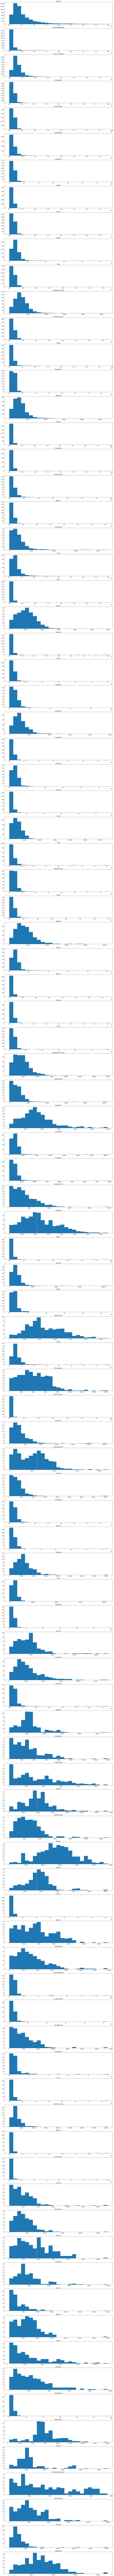

In [63]:
cities_cnts = train['city_new_2'].value_counts()
cities = cities_cnts[cities_cnts > 250].index
N = cities.size

plt.figure(figsize=(20, N*5))
for n, city in enumerate(cities_cnts[cities_cnts > 250].index):
    plt.subplot(N, 1, n+1)
    plt.hist(train[train['city_new_2'] == city]['per_square_meter_price'], bins=25)
    plt.title(city)